In [1]:
from pathlib import Path
import json
import csv
import pandas as pd
import numpy as np

In [2]:
# global flags
generate_graphs = True

In [ ]:
# font settings
if generate_graphs:
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['text.usetex'] = True

# Data Gathering
 - Gather json files into csv files

In [4]:
def gather_json(directory, typ):
    with (directory / 'data.csv').open('w') as csvfile:
        wr = csv.writer(csvfile, delimiter=',')
        wr.writerow(['benchmark', 'type', 'key', 'value'])

        for bench in directory.glob("*.json"):
            benchname = bench.stem
            if 'linear-algebra' in str(bench):
                benchname = bench.stem.split('-')[2]
            try:
                for key, value in json.load(bench.open()).items():
                    wr.writerow([benchname, typ, key, value])
            except json.JSONDecodeError as e:
                print(f"{bench} decode error: {e}")

In [5]:
# polybench standard
gather_json(Path("../results/standard/hls/"), 'hls')
gather_json(Path("../results/standard/futil/"), 'futil')
gather_json(Path("../results/standard/futil-latency/"), 'futil')

# polybench unrolled
gather_json(Path("../results/unrolled/hls/"), 'hls-unrolled')
gather_json(Path("../results/unrolled/futil/"), 'futil-unrolled')
gather_json(Path("../results/unrolled/futil-latency/"), 'futil-unrolled')

# systolic
gather_json(Path("../results/systolic/hls/"), 'systolic-hls')
gather_json(Path("../results/systolic/futil/"), 'systolic-futil')
gather_json(Path("../results/systolic/futil-no-static/"), 'systolic-futil-no-static')
# gather_json(Path("../results/systolic/futil-no-opts/"), 'systolic-futil-no-opts')
gather_json(Path("../results/systolic/futil-latency/"), 'systolic-futil')
gather_json(Path("../results/systolic/futil-no-static-latency/"), 'systolic-futil-no-static')

# latency sensitive
gather_json(Path("../results/latency-sensitive/no-static-timing/"), 'no-static-timing')
gather_json(Path("../results/latency-sensitive/with-static-timing/"), 'with-static-timing')

# optimizations
gather_json(Path("../results/opts/all/"), 'all')
gather_json(Path("../results/opts/minimize-regs/"), 'minimize-regs')
gather_json(Path("../results/opts/resource-sharing/"), 'resource-sharing')
gather_json(Path("../results/opts/none/"), 'none')
gather_json(Path("../results/opts/all-unrolled/"), 'all-unrolled')
gather_json(Path("../results/opts/minimize-regs-unrolled/"), 'minimize-regs-unrolled')
gather_json(Path("../results/opts/resource-sharing-unrolled/"), 'resource-sharing-unrolled')
gather_json(Path("../results/opts/none-unrolled/"), 'none-unrolled')

# Pandas data processing

## Gather Data + Cleanup
 - Throwaway keys irrelevant for the figures and do renaming

In [6]:
def cleanup(df, rename, include):
    df = df.copy()
    # rename
    for (key_name, key), v in rename.items():
        df.loc[df[key_name] == key, key_name] = v

    # only keep things in include
    return df[df['key'].isin(include)].reset_index(drop=True)

# polybench data
standard_hls = pd.read_csv("../results/standard/hls/data.csv")
standard_futil = pd.read_csv("../results/standard/futil/data.csv")
standard_futil_lat = pd.read_csv("../results/standard/futil-latency/data.csv")
unrolled_hls = pd.read_csv("../results/unrolled/hls/data.csv")
unrolled_futil = pd.read_csv("../results/unrolled/futil/data.csv")
unrolled_futil_lat = pd.read_csv("../results/unrolled/futil-latency/data.csv")
polybench_raw = standard_hls.append(standard_futil).append(standard_futil_lat).append(unrolled_hls).append(unrolled_futil).append(unrolled_futil_lat).reset_index(drop=True)
polybench = cleanup(polybench_raw, {
    ('key', 'avg_latency'): 'latency',
}, ['dsp', 'lut', 'latency'])

# systolic data
hls = pd.read_csv("../results/systolic/hls/data.csv")
futil = pd.read_csv("../results/systolic/futil/data.csv")
futil_dyn = pd.read_csv("../results/systolic/futil-no-static/data.csv")
# futil_no_opts = pd.read_csv("../results/systolic/futil-no-opts/data.csv")
futil_lat = pd.read_csv("../results/systolic/futil-latency/data.csv")
futil_dyn_lat = pd.read_csv("../results/systolic/futil-no-static-latency/data.csv")
systolic_raw = hls.append(futil).append(futil_dyn).append(futil_lat).append(futil_dyn_lat).reset_index(drop=True)
systolic = cleanup(systolic_raw, {
    ('key', 'avg_latency'): 'latency',
    ('benchmark', 'gemm2'): '2 x 2',
    ('benchmark', 'gemm4'): '4 x 4',
    ('benchmark', 'gemm6'): '6 x 6',
    ('benchmark', 'gemm8'): '8 x 8',
}, ['dsp', 'lut', 'latency'])

# latency insensitive data
with_static_timing = pd.read_csv('../results/latency-sensitive/with-static-timing/data.csv')
no_static_timing = pd.read_csv('../results/latency-sensitive/no-static-timing/data.csv')
latency_sensitive_raw = with_static_timing.append(no_static_timing).reset_index(drop=True)
latency_sensitive = cleanup(latency_sensitive_raw, {}, ['latency'])

# opts
opts_all = pd.read_csv('../results/opts/all/data.csv')
opts_mr = pd.read_csv('../results/opts/minimize-regs/data.csv')
opts_rs = pd.read_csv('../results/opts/resource-sharing/data.csv')
opts_none = pd.read_csv('../results/opts/none/data.csv')
opts_std = opts_all.append(opts_mr).append(opts_rs).append(opts_none)
opts_all = pd.read_csv('../results/opts/all-unrolled/data.csv')
opts_mr = pd.read_csv('../results/opts/minimize-regs-unrolled/data.csv')
opts_rs = pd.read_csv('../results/opts/resource-sharing-unrolled/data.csv')
opts_none = pd.read_csv('../results/opts/none-unrolled/data.csv')
opts_ur = opts_all.append(opts_mr).append(opts_rs).append(opts_none)
opts = opts_std.append(opts_ur).reset_index(drop=True)

## Calculate norms 

In [7]:
def match(df, benchmark, typ):
    return df[(df['benchmark'] == benchmark) & (df['type'] == typ)]

def _row_math(df, top_key, bot_key, name, op):
    df = df.copy()
    for bench in df['benchmark'].unique():
        norm = match(df, bench, top_key).copy()
        top = match(df, bench, top_key)['value']
        bot = match(df, bench, bot_key)['value']
        if len(top.values) == len(bot.values):
            norm['value'] = op(top.values,bot.values)
            norm['type'] = name
            df = df.append(norm)
    return df

def norm(df, top_key, bot_key, name):
    return _row_math(df, top_key, bot_key, name, lambda a, b: a / b)

        
polybench = norm(polybench, 'futil', 'hls', 'norm')
polybench = norm(polybench, 'futil-unrolled', 'hls-unrolled', 'norm-unrolled')
latency_sensitive = norm(latency_sensitive, 'with-static-timing', 'no-static-timing', 'norm')
opts = norm(opts, 'minimize-regs', 'none', 'minimize-regs-norm')
opts = norm(opts, 'resource-sharing', 'none', 'resource-sharing-norm')
opts = norm(opts, 'all', 'none', 'all-norm')
opts = _row_math(opts, 'none', 'minimize-regs', 'mr-diff', lambda a, b: b - a)
opts = _row_math(opts, 'none', 'resource-sharing', 'rs-diff', lambda a, b: b - a)
opts = _row_math(opts, 'none', 'all', 'all-diff', lambda a, b: b - a)

<ipython-input-7-0c21962cf13b>:17: RuntimeWarning: invalid value encountered in true_divide
  return _row_math(df, top_key, bot_key, name, lambda a, b: a / b)


## Dataframe formatting
 - Transition from long-form to short-form data by using `pivot`.
 - Reorder table so that unrolled benchmarks are grouped at the beginning

In [8]:
def pivot_and_order(df, order):
    df = df.pivot(index=['benchmark', 'type'], columns='key', values='value').reset_index()
    df['benchmark'] = pd.Categorical(df['benchmark'], order)
    return df

polybench_order = [
    '2mm', '3mm', 'atax','doitgen','gemm',
    'gemver','gesummv','gramschmidt','mvt',
    'syr2k', 'syrk','bicg','cholesky','durbin',
    'lu','ludcmp','symm','trisolv', 'trmm'
]

polybench = pivot_and_order(polybench, polybench_order)

systolic = pivot_and_order(systolic, [
    '2 x 2',
    '4 x 4',
    '6 x 6',
    '8 x 8'
])

latency_sensitive = pivot_and_order(latency_sensitive, polybench_order)
opts = pivot_and_order(opts, polybench_order)

## Helpers

In [9]:
def apply_legend(df, name, legend):
    df = df.copy()
    df = df[df[name].isin(list(legend.keys()))]
    df[name] = df[name].apply(lambda x: legend[x])
    return df

# Graph Generation

## 5a. Systolic Array Normalized cycle counts

Geomean Futil Speedup 4.853821595119907
Geomean Static Speedup 1.9773505116861632


array([1.93939394, 1.97530864, 1.98540146, 2.00995025])

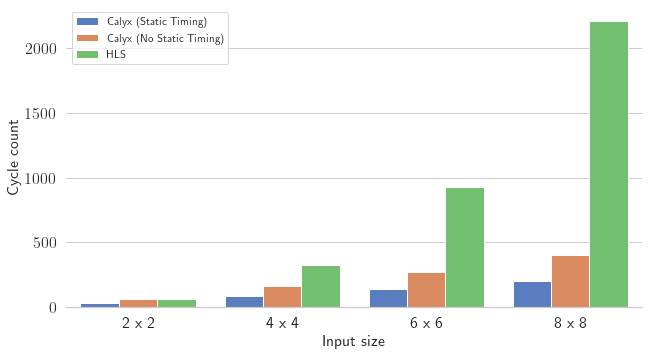

In [24]:
# figure 5 font settings
fig_fontsize=22

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'systolic-futil': 'Calyx (Static Timing)',
    'systolic-futil-no-static': 'Calyx (No Static Timing)',
    'systolic-hls': 'HLS',
}
g = sns.catplot(
    x="benchmark", 
    y="latency", 
    hue="type", 
    data=apply_legend(systolic, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
    hue_order=legend.values(),
    log=False
)
g.despine(left=True)
g.set_ylabels("Cycle count", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('systolic-lat.pdf')
    
futil_speedup = systolic[systolic['type'] == 'systolic-hls']['latency'].values / systolic[systolic['type'] == 'systolic-futil']['latency'].values
static_speedup = systolic[systolic['type'] == 'systolic-futil-no-static']['latency'].values / systolic[systolic['type'] == 'systolic-futil']['latency'].values
from scipy import stats
print('Geomean Futil Speedup', stats.gmean(futil_speedup))
print('Geomean Static Speedup', stats.gmean(static_speedup))
static_speedup

## 5b. Systolic Array Normalized LUT usage

Geomean Futil Speedup 2.14183544676126
Geomean Static Speedup 1.410032980181584


array([0.9027027 , 1.54535752, 1.67062174, 1.69615385])

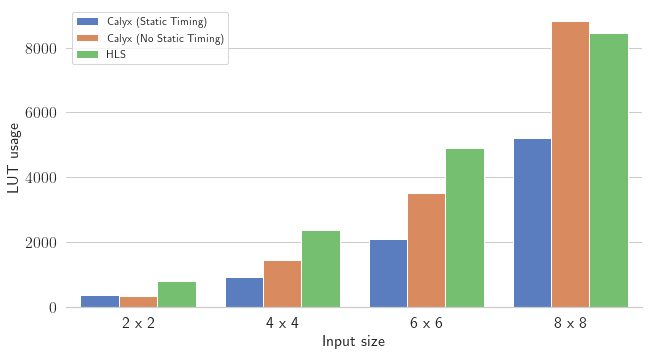

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'systolic-futil': 'Calyx (Static Timing)',
    'systolic-futil-no-static': 'Calyx (No Static Timing)',
    'systolic-hls': 'HLS',
}
g = sns.catplot(
    x="benchmark", 
    y="lut", 
    hue="type", 
    data=apply_legend(systolic, 'type', legend),
    kind="bar", 
    palette="muted",
    hue_order=legend.values(),
    legend=False,
)
g.despine(left=True)
g.set_ylabels("LUT usage", fontsize=16)
g.set_xlabels("Input size", fontsize=16)
g.set_yticklabels(fontsize=16)
g.set_xticklabels(fontsize=16)
g.axes[0,0].legend(loc='upper left',).set_title('')
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('systolic-lut.pdf')
    
futil_speedup = systolic[systolic['type'] == 'systolic-hls']['lut'].values / systolic[systolic['type'] == 'systolic-futil']['lut'].values
static_speedup = systolic[systolic['type'] == 'systolic-futil-no-static']['lut'].values / systolic[systolic['type'] == 'systolic-futil']['lut'].values
from scipy import stats
print('Geomean Futil Speedup', stats.gmean(futil_speedup))
print('Geomean Static Speedup', stats.gmean(static_speedup))
static_speedup

## 6a. Cycle counts normalized to Vivado HLS

Geometric mean (rolled) 3.0931645698563144
Geometric mean (unrolled) 2.3890827964246406
rolled [4.1880043  3.46757882 3.15384615 4.96788991 1.81516245 3.40178756
 2.4726776  3.45193741 3.36561086 4.15225564 2.05964369 1.75619152
 2.62195883 3.11725293 4.78160354 4.62904095 4.58950969 1.22015915
 3.38377334]
unrolled [1.48436337 1.49803328 3.32768362 2.25892945 1.44021739 2.17363752
 3.26757812 2.01017322 2.17814727 4.38809122 4.40554156]


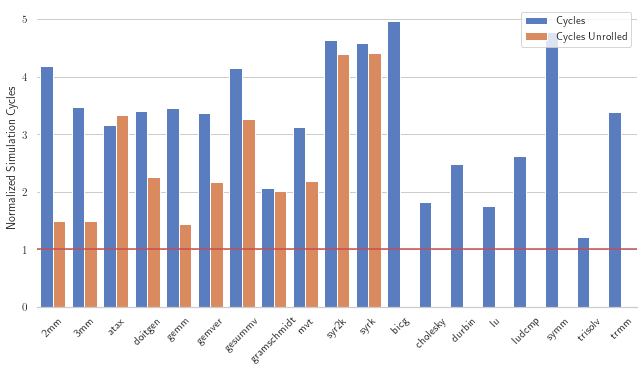

In [12]:
# figure 6 font settings
fig_fontsize=24

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'Cycles',
    'norm-unrolled': 'Cycles Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
g = sns.catplot(
    x="benchmark",
    y="latency",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Simulation Cycles")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('unrolled-lat-sen-cycles.pdf')
    
from scipy import stats
norm = df[df['type'] == 'norm']['latency'].values
norm_ur = df[df['type'] == 'norm-unrolled']['latency'].values
print('Geometric mean (rolled)', stats.gmean(norm))
print('Geometric mean (unrolled)', stats.gmean(norm_ur))
print('rolled', norm)
print('unrolled', norm_ur)

## 6b. LUT usage normalized to Vivado HLS

Geometric mean (rolled) 1.246138617337231
Geometric mean (unrolled) 2.2025734337462977
rolled [4.31842386 0.75471698 2.12622951 0.95107034 0.14059406 0.70080863
 0.7588785  3.84202212 1.77503737 3.08730159 0.96107355 0.60209424
 0.75721455 2.02587519 1.21857923 3.69421488 2.4524181  0.65789474
 0.97805643]
unrolled [2.10551763 2.02533276 1.87096774 5.17253774 2.25282051 1.70643087
 2.19742729 1.01262549 1.88543976 3.77858628 2.35336049]


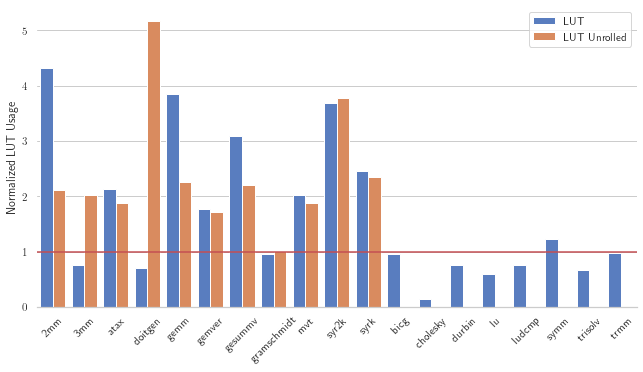

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'norm': 'LUT',
    'norm-unrolled': 'LUT Unrolled'
}

df = polybench[polybench['type'].isin(['norm', 'norm-unrolled'])]
g = sns.catplot(
    x="benchmark",
    y="lut",
    hue="type",
    data=apply_legend(df, 'type', legend),
    kind="bar",
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized LUT Usage")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.axes[0,0].legend(loc='upper right').set_title('')
g.axes[0,0].axhline(1, color="r")
g.fig.set_size_inches(10,5)
if generate_graphs:
    g.savefig('unrolled-lat-sen-lut.pdf')
    
from scipy import stats
norm = df[df['type'] == 'norm']['lut'].values
norm_ur = df[df['type'] == 'norm-unrolled']['lut'].values
print('Geometric mean (rolled)', stats.gmean(norm))
print('Geometric mean (unrolled)', stats.gmean(norm_ur))
print('rolled', norm)
print('unrolled', norm_ur)

## 6c. Cycle counts normalized to latency-insensitive design 

Geometric mean 0.3639536919298887


array([0.51788581, 0.52702007, 0.51796009, 0.60572484, 0.22275259,
       0.01044888, 0.46519337, 0.48354021, 0.50766335, 0.62652784,
       0.41261484, 0.30711376, 0.28360695, 0.53734551, 0.4345232 ,
       0.47349124, 0.49341615, 0.36521739, 0.44757374])

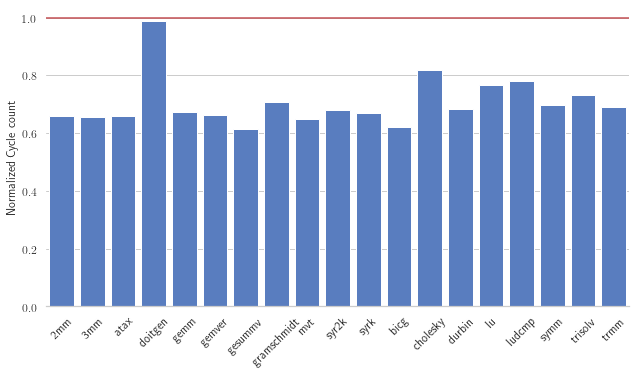

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

df = latency_sensitive
g = sns.catplot(
    x="benchmark", 
    y="latency",
    hue="type",
    data=df[df['type'] == 'norm'],
    kind="bar", 
    palette="muted",
    legend=False,
)
g.despine(left=True)
g.set_ylabels("Normalized Cycle count", fontsize=fig_fontsize)
g.set_xlabels("", fontsize=fig_fontsize)
g.set_xticklabels(fontsize=fig_fontsize, rotation=-45, ha="left", rotation_mode="anchor")
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(fig_fontsize) # I hate this, but otherwise the axes would be wrong
g.fig.set_size_inches(10,5)

if generate_graphs:
    g.savefig('norm-lat-sen-insen.pdf', dpi=400)
    
from scipy import stats
speedup = (df[df['type'] == 'no-static-timing']['latency'].values / df[df['type'] == 'with-static-timing']['latency'].values)
print('Geometric mean', stats.gmean(speedup - 1))
speedup - 1

# Optimizations

In [ ]:
# fontsize
fig_fontsize=22

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'resource-sharing-norm': 'Resource Sharing',
    'minimize-regs-norm': 'Register Sharing',
    'all-norm': 'Both Enabled'
}

g = sns.catplot(
    x="benchmark", 
    y="lut",
    hue="type",
    data=apply_legend(opts, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
    hue_order=legend.values(),
)
g.despine(left=True)
g.set_ylabels("Normalized LUT", fontsize=fig_fontsize)
g.set_xlabels("", fontsize=fig_fontsize)
g.set_xticklabels(fontsize=fig_fontsize, rotation=-45, ha="left", rotation_mode="anchor")
g.axes[0,0].legend(loc='lower right', fontsize=fig_fontsize-2).set_title('')
g.fig.set_size_inches(10,5)

g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong
if generate_graphs:
    g.savefig('norm-opts-lut.pdf', dpi=400)
    
df = apply_legend(opts, 'type', legend)
from scipy import stats
print('Resorce Sharing Mean', stats.gmean(df[df['type'] == 'Resource Sharing']['clb'].values))
print('Register Sharing 1 - Mean', 1 - stats.gmean(df[df['type'] == 'Register Sharing']['clb'].values))

Register Sharing 1 - Mean 0.12191436585600368


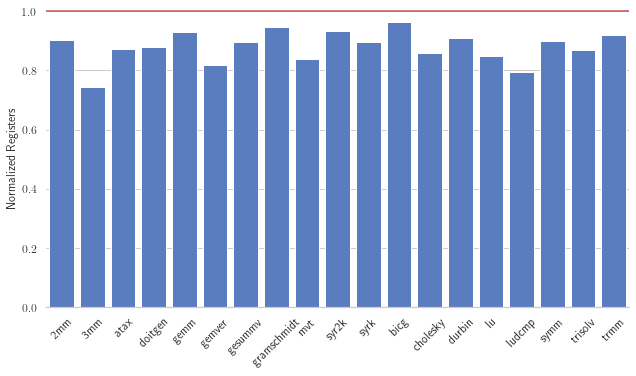

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

legend = {
    'minimize-regs-norm': 'Registers',
}

g = sns.catplot(
    x="benchmark", 
    y="registers",
    hue="type",
    data=apply_legend(opts, 'type', legend),
    kind="bar", 
    palette="muted",
    legend=False,
    hue_order=legend.values(),
)
g.despine(left=True)
g.set_ylabels("Normalized Registers", fontsize=12)
g.set_xlabels("")
g.set_xticklabels(rotation=45, fontsize=12)
# g.axes[0,0].legend(loc='lower right').set_title('')
g.fig.set_size_inches(10,5)

g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong
if generate_graphs:
    g.savefig('norm-opts-regs.pdf', dpi=400)
    
df = apply_legend(opts, 'type', legend)
from scipy import stats
print('Register Sharing 1 - Mean', 1 - stats.gmean(df[df['type'] == 'Registers']['registers'].values))

In [20]:
df = opts[opts['type'] == 'rs-diff'].reset_index(drop=True)
cells = list(map(lambda x: f"cell_lut{x}", range(1,7))) + ['cell_fdre', 'clb']
df = df[['benchmark'] + cells].melt(id_vars=['benchmark'])
g = sns.catplot(
    x='benchmark',
    y='value',
    hue='key',
    kind='bar',
    data=df
)
g.despine(left=True)
# g.set_ylabels("Normalized Cycle count", fontsize=12)
g.set_xlabels("")
g.set_xticklabels(rotation=-45, fontsize=12)
g.fig.set_size_inches(20,10)

# g.axes[0,0].axhline(1, color='r')
for l in g.axes[0,0].get_yticklabels(): l.set_fontsize(12) # I hate this, but otherwise the axes would be wrong


RuntimeError: latex was not able to process the following string:
b'cell_lut1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/samthomas/.cache/matplotlib/tex.cache/88ed15b8dc61cecc0d01040e53b0aa93.t
ex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-07-17>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./88ed15b8dc61cecc0d01040e53b0aa93.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily cell_
                     lut1}
No pages of output.
Transcript written on 88ed15b8dc61cecc0d01040e53b0aa93.log.




RuntimeError: latex was not able to process the following string:
b'cell_lut1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/samthomas/.cache/matplotlib/tex.cache/88ed15b8dc61cecc0d01040e53b0aa93.t
ex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-07-17>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./88ed15b8dc61cecc0d01040e53b0aa93.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily cell_
                     lut1}
No pages of output.
Transcript written on 88ed15b8dc61cecc0d01040e53b0aa93.log.




<Figure size 360x360 with 1 Axes>